In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
from sklearn.cross_validation import StratifiedKFold
import lasagne
import theano
from lasagne.layers import InputLayer
from lasagne.layers.dnn import Conv3DDNNLayer
from lasagne.layers.dnn import Pool3DDNNLayer
from lasagne.layers import BatchNormLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import DenseLayer
from lasagne.nonlinearities import identity, softmax
from lasagne.layers import DropoutLayer
import theano.tensor as T
import pickle
from skimage.transform import rotate
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow
import copy
import glob
import nibabel
from skimage.transform import resize

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5110)


In [2]:
input_var = T.tensor5(name='input', dtype='float32')
target_var = T.ivector()
inp_shape = (None, 1, 110, 110, 110)

In [3]:
modelname = 'models/pretrained_vgg.npz'

In [4]:
def build_net():
    """Method for VGG like net Building.

    Returns
    -------
    nn : lasagne.layer
        Network.
    """
    nn = {}
    nn['input'] = InputLayer(inp_shape, input_var=input_var)

    nn['conv1a'] = Conv3DDNNLayer(nn['input'], 8, 3)
    nn['conv1b'] = Conv3DDNNLayer(nn['conv1a'], 8, 3, nonlinearity=identity)
    nn['nl1'] = NonlinearityLayer(nn['conv1b'])
    nn['pool1'] = Pool3DDNNLayer(nn['nl1'], 2)

    nn['conv2a'] = Conv3DDNNLayer(nn['pool1'], 16, 3)
    nn['conv2b'] = Conv3DDNNLayer(nn['conv2a'], 16, 3, nonlinearity=identity)
    nn['nl2'] = NonlinearityLayer(nn['conv2b'])
    nn['pool2'] = Pool3DDNNLayer(nn['nl2'], 2)

    nn['conv3a'] = Conv3DDNNLayer(nn['pool2'], 32, 3)
    nn['conv3b'] = Conv3DDNNLayer(nn['conv3a'], 32, 3)
    nn['conv3c'] = Conv3DDNNLayer(nn['conv3b'], 32, 3, nonlinearity=identity)
    nn['nl3'] = NonlinearityLayer(nn['conv3c'])
    nn['pool3'] = Pool3DDNNLayer(nn['nl3'], 2)

    nn['conv4a'] = Conv3DDNNLayer(nn['pool3'], 64, 3)
    nn['conv4b'] = Conv3DDNNLayer(nn['conv4a'], 64, 3)
    nn['conv4c'] = Conv3DDNNLayer(nn['conv4b'], 64, 3, nonlinearity=identity)
    nn['nl4'] = NonlinearityLayer(nn['conv4c'])
    nn['pool4'] = Pool3DDNNLayer(nn['nl4'], 2)

    nn['dense1'] = DenseLayer(nn['pool4'], num_units=128)
    nn['bn'] = BatchNormLayer(nn['dense1'])
    nn['dropout'] = DropoutLayer(nn['bn'], p=0.7)

    nn['dense2'] = DenseLayer(nn['dropout'], num_units=64)
    
    #nn['pool4'] = GlobalPoolLayer(nn['nl4'])

    nn['prob'] = DenseLayer(nn['dense2'], num_units=2,
                    nonlinearity=lasagne.nonlinearities.softmax)
    return nn


In [5]:
net = build_net()
test_prediction = lasagne.layers.get_output(net['prob'], deterministic=True)
test_fn = theano.function([input_var], test_prediction)

In [6]:
with np.load(modelname) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

lasagne.layers.set_all_param_values(net['prob'], param_values)

In [7]:
mx = nib.load('image/example.nii').get_data().max(axis=0).max(axis=0).max(axis=0)
mri = np.array(nib.load('image/example.nii').get_data()) / mx
mri_rz = resize(mri,(256,256,256))

In [8]:
level_list = glob.glob('image/3DUCM/example_level_*')
prob_list = []
for k in tqdm(range(len(level_list))):

    segname = level_list[k]
    segs = np.load(segname)
    segs = np.flipud(segs)

    s0, s1, s2 = mri.shape
    num_classes = 2
    probs = np.zeros((s0, s1, s2, num_classes))
    seg_array = np.unique(segs)

    for j in range(len(seg_array)):

        x_occluded = copy.deepcopy(mri)
        x_occluded[np.where(segs==seg_array[j])] = 0
        y_proba = test_fn(np.array(x_occluded).reshape((-1, 1, 110, 110, 110)))
        probs[np.where(segs==seg_array[j])] = y_proba
        #print(y_proba)

    prob_list.append(probs)

prob_map = np.zeros(mri.shape)

for ll in range(len(prob_list)):
    prob_map = prob_map + prob_list[ll][:,:,:,0]

prob_map = prob_map / np.float(len(prob_list))

res = (prob_map - np.min(prob_map)) / (np.max(prob_map) - np.min(prob_map))

100%|██████████| 19/19 [01:07<00:00,  5.09s/it]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:31: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: MatplotlibDeprecationWarning: p

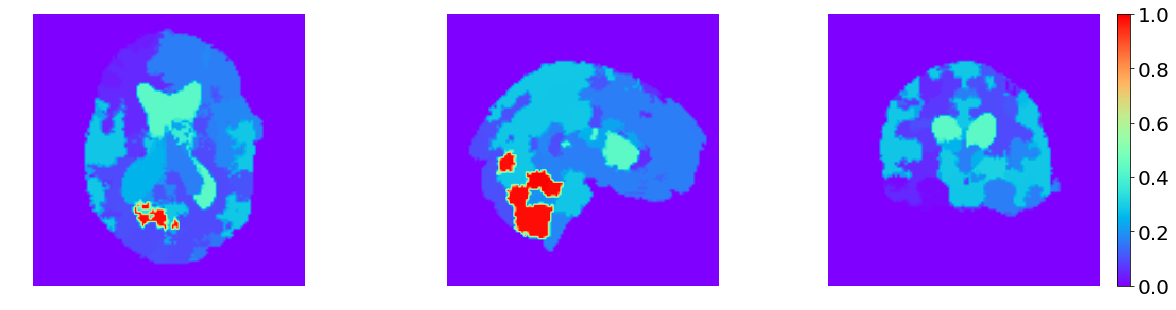

In [9]:
seg0_name = 'image/3DUCM/example_level_00.npy'
seg0 = np.load(seg0_name)
seg0 = np.flipud(seg0)
seg0_array = np.unique(seg0)
vox_cnt = []

for cc in range(len(seg0_array)):
    vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

res[np.where(seg0==bg_seg)] = 0

res = resize(res,(256,256,256))

fig = plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
plt.hold(True)
matr = rotate(res[:, :, 128].reshape(256, 256), 90)
plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
plt.subplot(1, 3, 2)
plt.axis('off')
matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
plt.hold(True)
matr = rotate(res[128,:, :].reshape(256, 256), 90)
plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
plt.subplot(1, 3, 3)
plt.axis('off')
matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
plt.hold(True)
matr = rotate(res[:,128, :].reshape(256, 256), 90)
plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()